# Matrix Analysis 2023 - EE312
[LTS2](https://lts2.epfl.ch)
## Autoregressive model - Recursive least squares

In [1]:
import json
import requests
import urllib.parse
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pages_list = ['Invertible matrix']#, 'Moore–Penrose inverse', 'Matrix (mathematics)', 'Pseudoinverse', 'Ordinary least squares']
wiki_baseurl = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/{}/daily/{}/{}'
start_date = '2021010100' # format is yyyyMMddhh
end_date = '2021123100' 

In [3]:
def build_page_url(baseurl, page, startdate, enddate):
    p = urllib.parse.quote(page.replace(' ', '_'))
    return baseurl.format(p, startdate, enddate)

def get_pagevisit_data(baseurl, page, startdate, enddate):
    pu = build_page_url(wiki_baseurl, page, start_date, end_date)
    user_agent = {'User-agent': 'Mozilla/5.0'} # needed otherwise requests are blocked
    r = requests.get(pu, headers=user_agent)
    d = r.json() # wikipedia api returns json data
    v = [d['items'][k]['views'] for k in range(len(d['items']))]
    return np.array(v)

def getall_pagevisit(baseurl, pagelist, startdate, enddate):
    return np.array([get_pagevisit_data(baseurl, p, startdate, enddate) for p in pagelist])

In [4]:
v = getall_pagevisit(wiki_baseurl, pages_list, start_date, end_date)

We will use wikipedia pageview data to predict time series values. You can use the [online tool](https://pageviews.wmcloud.org/?project=en.wikipedia.org&platform=all-access&agent=user&redirects=0&range=latest-20&pages=Cat|Dog) to explore pageview data interactively. 

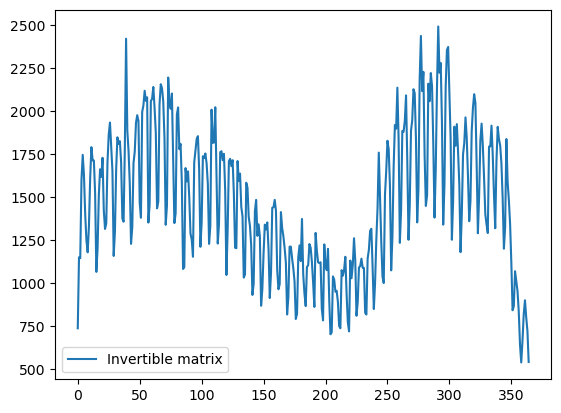

In [5]:
for k in range(len(v)):
    plt.plot(v[k, :])
plt.legend(pages_list)
plt.show()

Each row of the matrix $A$ will be the last $N$ pageview data. We will use 40 of these data and $N=30$ to initialize the recursive least-squares.

In [6]:
def buildA(v, N, M):
    A = np.zeros((M, N))
    for k in range(M):
        A[k, :] = v[k:k+N]
    return A

In [7]:
A = buildA(v[0, :], 30, 40)

$y$ contains the "next" pageviews value

In [8]:
y=v[0, 20:60]

In [9]:
x=np.linalg.inv(A.T@A)@A.T@y

In [10]:
x

array([-5.13311615e-13,  6.03073147e-13, -1.40465417e-12,  7.79820652e-13,
       -9.81437154e-13,  3.29958283e-13, -6.94111435e-13,  7.20534743e-13,
       -4.62518912e-13,  2.67008637e-13, -2.17159624e-13, -1.03472786e-13,
        8.57092175e-14, -4.84057239e-14,  2.39364084e-13, -1.57429625e-13,
        3.40616424e-13,  2.26485497e-13,  2.42916798e-13,  4.44089210e-14,
        1.00000000e+00, -9.37028233e-14, -1.83408844e-13,  2.79776202e-13,
       -3.33122419e-13,  4.22550883e-13, -1.88737914e-15, -9.34807787e-14,
        3.01647596e-13, -2.89213098e-14])

In [11]:
A@x

array([1729., 1425., 1315., 1347., 1705., 1865., 1934., 1795., 1651.,
       1158., 1300., 1664., 1848., 1810., 1826., 1702., 1376., 1357.,
       1792., 2422., 1887., 1767., 1575., 1228., 1324., 1698., 1765.,
       1933., 1977., 1943., 1467., 1380., 1996., 2034., 2119., 2060.,
       2081., 1352., 1458., 2059.])

In [12]:
y

array([1729, 1425, 1315, 1347, 1705, 1865, 1934, 1795, 1651, 1158, 1300,
       1664, 1848, 1810, 1826, 1702, 1376, 1357, 1792, 2422, 1887, 1767,
       1575, 1228, 1324, 1698, 1765, 1933, 1977, 1943, 1467, 1380, 1996,
       2034, 2119, 2060, 2081, 1352, 1458, 2059])

In [13]:
Pinv = np.linalg.inv(A.T@A)

In [14]:
q = A.T@y

Check the initial prediction is accurate

In [15]:
A@Pinv@q-y

array([ 8.22183210e-10, -6.40284270e-10, -5.82076609e-11, -6.98491931e-10,
       -1.10594556e-09, -9.89530236e-10,  2.61934474e-10, -2.91038305e-10,
       -4.07453626e-10, -2.32830644e-10, -4.80213203e-10,  1.13504939e-09,
       -9.31322575e-10,  8.73114914e-11, -1.22236088e-09, -1.74622983e-10,
       -1.01135811e-09, -3.01952241e-10, -6.83940016e-10, -3.34694050e-10,
       -9.89530236e-10,  5.52972779e-10, -1.21508492e-09, -1.06228981e-09,
        2.91038305e-11, -1.39698386e-09, -1.48429535e-09, -1.04773790e-09,
       -5.52972779e-10, -2.91038305e-11, -5.49334800e-10,  1.52795110e-10,
       -6.91215973e-10, -4.51109372e-10,  5.52972779e-10, -8.73114914e-10,
       -7.56699592e-10, -1.39698386e-09,  1.33877620e-09, -1.74622983e-09])

If we add a new measurement row $a$ and a new value $y$ (the next in the time series), we can update $P^{-1}$ and $x$ using the Sherman-Morrison formula:

$(P + aa^T)^{-1} = P^{-1}-\frac{1}{1+a^TP^{-1}a}(P^{-1}a)(P^{-1}a)^T$ and 

$x_{new}=x+\frac{1}{1+a^TP^{-1}a}(y-ax)P^{-1}a$

In [16]:
def rls_step(Pinv, x, anew, ynew):
    z = Pinv@anew
    alpha = 1/(1 + anew.T@z) 
    Pnext = Pinv - alpha*(Pinv@anew.T)@(anew@Pinv)
    xnext = x + z*alpha*(ynew - anew@x)
    return Pnext, xnext

In [17]:
Pnext, xnext=rls_step(Pinv, x, v[0, 40:70], v[0, 70])

In [18]:
v[0, 40:70]

array([1887, 1767, 1575, 1228, 1324, 1698, 1765, 1933, 1977, 1943, 1467,
       1380, 1996, 2034, 2119, 2060, 2081, 1352, 1458, 2059, 2072, 2141,
       2019, 1874, 1435, 1474, 2039, 2157, 2134, 2058])

Predict next value

In [19]:
v[0, 40:70]@xnext

1910.6045816915498

In [20]:
v[0, 70]

1844

In [21]:
def rls_iter(Pinv, x, v, N, M, niter):
    pred = []
    res = []
    gt = []
    Pcur = Pinv
    xcur = x
    for k in range(niter):
        a = v[0, M+k:M+N+k]
        Pnext, xnext = rls_step(Pcur, xcur, a, v[0, M+k])
        pred.append(a@xcur)
        res.append(a@xnext)
        gt.append(v[0, M+k])
        Pcur = Pnext
        xcur = xnext
    return pred, res, gt

In [22]:
pred, res, gt = rls_iter(Pinv, x, v, 30, 40, 100)

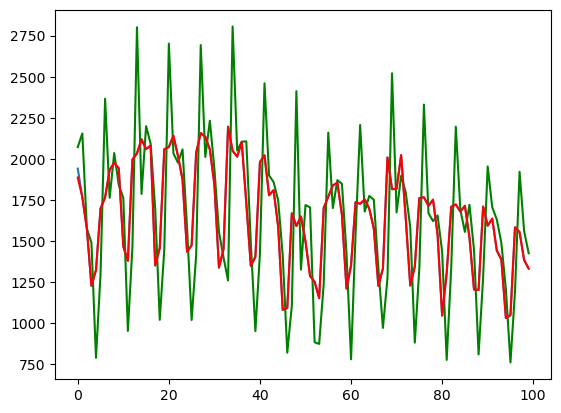

In [23]:
plt.plot(pred, 'g')
plt.plot(res)
plt.plot(gt, 'r')

Once updated the model follows perfectly the measurements. The green line (i.e. the next prediction of the current model) overshoots the prediction but corrects itself when adding more measurements.

Initialization step has a non-negligible impact on the results, if we replace $P$ by the identity matrix and set the initial $x$ to duplicate the last sample of the measurement, prediction is less accurate (and suffer some delay).

In [24]:
x_e = np.ones(30)
x_e[29] = 1.
pred_eye, res_eye, gt_eye = rls_iter(np.eye(30), x_e, v, 30, 40, 100)

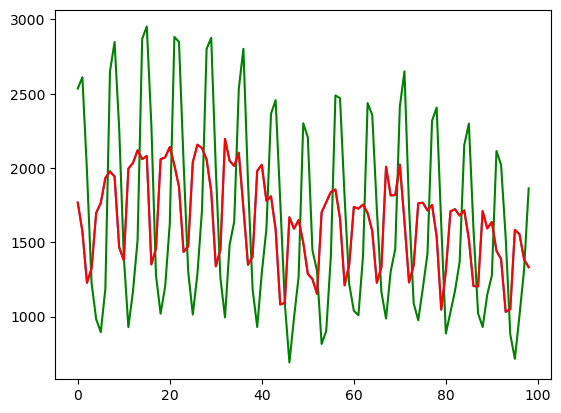

In [25]:
plt.plot(pred_eye[1:], 'g')
plt.plot(res_eye[1:])
plt.plot(gt_eye[1:], 'r')

If you do not update the initial model, you get substiantially worse results (but not completely implausible).

In [26]:
def noupd_iter(x, v, N, M, niter):
    res = []
    gt = []
    for k in range(niter):
        a = v[0, M+k:M+N+k]
        res.append(a@x)
        gt.append(v[0, M+k])
    return res, gt

In [27]:
pred_n, gt_n = noupd_iter(x, v, 30, 40, 100)

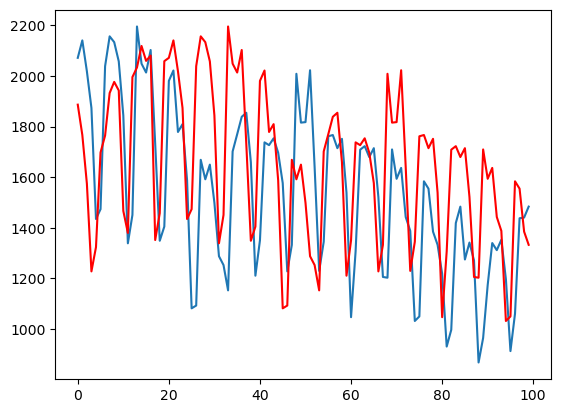

In [28]:
plt.plot(pred_n)
plt.plot(gt_n, 'r')